# Latex compatible appearance

In [1]:
import seaborn as sns

custom_params = {
    "xtick.direction": "in",
    "ytick.direction": "in",
    "lines.markeredgecolor": "k",
    "lines.markeredgewidth": 1.25,
    "figure.dpi": 200,
    "text.usetex": True,
    "font.family": "serif"}
sns.set_theme(context = "talk", style="ticks", rc=custom_params) 

In [2]:
# Loading Cython library
%load_ext Cython

In [3]:
%%cython

import cython
import numpy as np
cimport numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sp
from scipy.stats import pearsonr
from scipy.interpolate import interp1d
from tqdm import tqdm
ctypedef np.float64_t dtype_t

cdef int N = 10_000_000
cdef dtype_t tau = 1e-4
cdef dtype_t kbT = 1.
cdef dtype_t beta = 1/kbT
cdef dtype_t Gamma_0 = 1.

cdef dtype_t g_11 = np.sqrt(Gamma_0) * 1.
cdef dtype_t g_12 = np.sqrt(Gamma_0) * 2.2
cdef dtype_t g_22 = np.sqrt(Gamma_0) * 10.

cdef dtype_t gamma_11 = g_11 ** 2 + g_12 ** 2
cdef dtype_t gamma_12 = g_12 * ( g_11 + g_22 )
cdef dtype_t gamma_22 = g_22 ** 2 + g_12 ** 2

cdef dtype_t gamma_ratio_22 = gamma_12 / gamma_22
cdef dtype_t gamma_ratio_11 = gamma_12 / gamma_11

cdef dtype_t alpha_1 = 1.

cdef dtype_t l_1 = 1.
cdef dtype_t kappa_2 = 1.0e-3
cdef dtype_t[:] q1 = np.zeros(N)
cdef dtype_t[:] q2 = np.zeros(N)

def phi_second_1(q) :
    return - 4 * np.pi**2 * alpha_1/l_1**2 * np.sin(2 * np.pi * q/l_1)


def phi_prime_1(q) :
    return 2 * np.pi * alpha_1/l_1 * np.cos(2 * np.pi * q/l_1)

def phi_prime_2(q) :
    return q/kappa_2

def phi_1(q) :    
    return alpha_1 * np.sin(2 * np.pi * q/l_1)

def phi_2(q) :
    return q**2 / (2 * kappa_2)    





def pdf(q, bins=100, density=True):
    pdf_q, bins_edge_q = np.histogram(q, bins=bins, density=density)
    bins_center_q = (bins_edge_q[0:-1] + bins_edge_q[1:]) / 2
    return pdf_q, bins_center_q

def _Peq_projection1D_q1(q1) :
    return np.exp(-beta * (phi_1(q1)))

def _Peq_projection1D_q2(q2) :
    return np.exp(-beta * (phi_2(q2)))

def Peq_projection1D_q1(q1): # Normalised equilibrium distribution
    P = np.array([_Peq_projection1D_q1(q1i) for q1i in q1])
    return P / np.trapz(P, q1)

def Peq_projection1D_q2(q2): # Normalised equilibrium distribution
    P = np.array([_Peq_projection1D_q2(q2i) for q2i in q2])
    return P / np.trapz(P, q2)



@cython.boundscheck(False)
@cython.wraparound(False)
@cython.nonecheck(False)
@cython.cdivision(True)
cdef void qi_full_arrays(dtype_t[:] q1, dtype_t[:] q2, dtype_t[:] eta_1, dtype_t[:] eta_2):
    cdef dtype_t[:] q1_theo = np.linspace(-1, 1, N) # Vague range of q1, start from equilibrium purposes
    cdef dtype_t[:] q2_theo = np.linspace(-.5, .5, N) # Vague range of q2

    cdef dtype_t[:] phi_prime_1_ = np.zeros(N)
    cdef dtype_t[:] phi_prime_2_ = np.zeros(N)

    inverse_cdf_q1 = sample(q1_theo, Peq_projection1D_q1)
    inverse_cdf_q2 = sample(q2_theo, Peq_projection1D_q2)
    
    q1[0] = inverse_cdf_q1(np.random.uniform(0.0000001, 1 - 0.0000001))
    q2[0] = inverse_cdf_q2(np.random.uniform(0.0000001, 1 - 0.0000001))
    
    cdef int i
    for i in range(1, N):     
        q1[i], q2[i] = update_q_values(
            q1[i - 1], q2[i - 1], phi_prime_1(q1[i-1]), 
            phi_prime_2(q2[i-1]), eta_1[i - 1], eta_2[i - 1]
            )





@cython.boundscheck(False)
@cython.wraparound(False)
@cython.nonecheck(False)
cdef update_q_values(
    dtype_t q1_current, dtype_t q2_current, dtype_t phi_prime_1_current, 
    dtype_t phi_prime_2_current, dtype_t eta_1_current, dtype_t eta_2_current ):

    q1_next = q1_current + (gamma_11 - (gamma_12**2 / gamma_22))**(-1) * (
        tau * (- phi_prime_1_current + gamma_ratio_22 * phi_prime_2_current) +
        eta_1_current - gamma_ratio_22 * eta_2_current)
    
    q2_next = q2_current + (gamma_22 - (gamma_12**2 / gamma_11))**(-1) * (
        tau * (- phi_prime_2_current + gamma_ratio_11 * phi_prime_1_current) +
        eta_2_current - gamma_ratio_11 * eta_1_current)
    
    return q1_next, q2_next


def q1q2_trajectories_sinusoidal_trap() :
    cdef dtype_t[:] xi_1 = np.sqrt(2) * np.random.normal(0, np.sqrt(tau), N)

    cdef dtype_t[:] xi_2 = np.sqrt(2) * np.random.normal(0, np.sqrt(tau), N)


    cdef dtype_t[:] eta_1 = g_11 * np.asarray(xi_1) + g_12 * np.asarray(xi_2)

    cdef dtype_t[:] eta_2 = g_12 * np.asarray(xi_1) + g_22 * np.asarray(xi_2)

    qi_full_arrays(q1, q2, eta_1, eta_2)
    
    return np.asarray(q1), np.asarray(q2)


def sample(q_sample, Peq_projection1D_q) : # Correct this 
    y_q = Peq_projection1D_q(q_sample) # y = Peq ( z )
    cdf_y_q = np.cumsum(y_q)
    cdf_y_q = cdf_y_q/cdf_y_q.max() # Normalisation
    inverse_cdf_q = interp1d(cdf_y_q,q_sample) # fonction inverse
    return inverse_cdf_q







Content of stderr:
In file included from /Users/juls/.ipython/cython/_cython_magic_cf1ebdf19c64fe810374e1ea900be76959839fc6.c:1250:
In file included from /Users/juls/Library/Python/3.9/lib/python/site-packages/numpy/_core/include/numpy/arrayobject.h:5:
In file included from /Users/juls/Library/Python/3.9/lib/python/site-packages/numpy/_core/include/numpy/ndarrayobject.h:12:
In file included from /Users/juls/Library/Python/3.9/lib/python/site-packages/numpy/_core/include/numpy/ndarraytypes.h:1909:
/Users/juls/Library/Python/3.9/lib/python/site-packages/numpy/_core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: "Using deprecated NumPy API, disable it with "          "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-W#warnings]
   17 | #warning "Using deprecated NumPy API, disable it with " \
      |  ^
/Users/juls/.ipython/cython/_cython_magic_cf1ebdf19c64fe810374e1ea900be76959839fc6.c:29196:26: warning: code will never be executed [-Wunreachable-code]
 29196 |                

In [4]:
q1, q2 = q1q2_trajectories_sinusoidal_trap() ## bm 33s

/var/folders/cn/hc6sy9vj2vlchg2np1k_bvvh0000gn/T/ipykernel_9713/2558833863.py:1: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  q1, q2 = q1q2_trajectories_sinusoidal_trap() ## bm 33s


# Plotting the trajectories

In [5]:
N = 10_000_000
tau = 1e-4
kbT = 1.
beta = 1/kbT

l_1 = 1.
kappa_2 = 1.0e-3


#G matrix
Gamma_0 = 1.
g_11 = np.sqrt(Gamma_0) * 1.
g_12 = np.sqrt(Gamma_0) * 2.2
g_22 = np.sqrt(Gamma_0) * 10.

det_g = g_11*g_22-g_12**2

#Gamma matrix
gamma_11 = g_11**2 + g_12**2
gamma_12 = g_12* (g_11 + g_22)
gamma_22 = g_22**2 + g_12**2
gamma_ratio_22 = gamma_12 / gamma_22
gamma_ratio_11 = gamma_12 / gamma_11



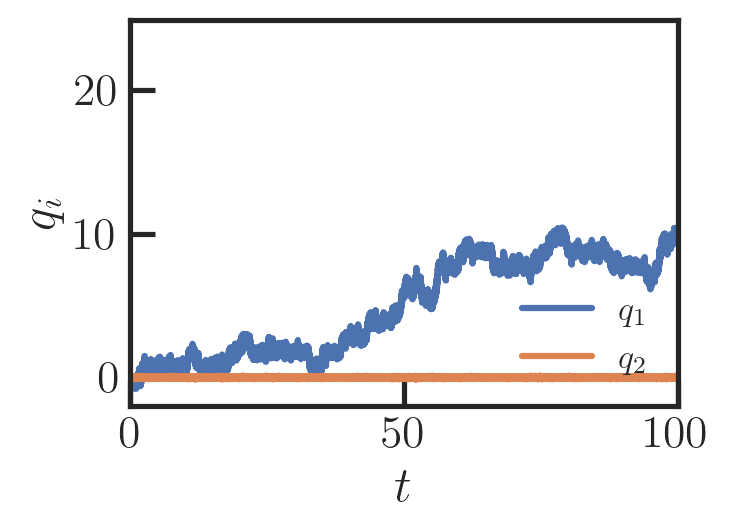

In [6]:
plt.figure(figsize= (4, 3), dpi = 200)

plt.plot((np.arange(N))*tau, q1, label = "$q_1$")
plt.plot((np.arange(N))*tau, q2, label = "$q_2$")
# plt.grid()
plt.ylabel("$q_i$")
plt.xlabel("$t$")
plt.xlim(-0.04, 100)
# plt.ylim(-1, 3)
plt.legend(fontsize='x-small', loc='lower right', frameon = False)

plt.tight_layout()
plt.savefig("trajectories.pdf", format = "pdf", transparent = True)
plt.show()

In [7]:
q1_histo, q1_bins_center = pdf(q1%(l_1), bins=20, density = True)
# q2_histo, q2_bins_center = pdf(q2, bins=1000, density = True)

In [8]:
q1theo = np.linspace(0, l_1, N)
Projection_q1 = Peq_projection1D_q1(q1theo)
# Projection_q2 = Peq_projection1D_q2(np.linspace(-.2, .2, N))

/var/folders/cn/hc6sy9vj2vlchg2np1k_bvvh0000gn/T/ipykernel_9713/3895125009.py:2: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  Projection_q1 = Peq_projection1D_q1(q1theo)


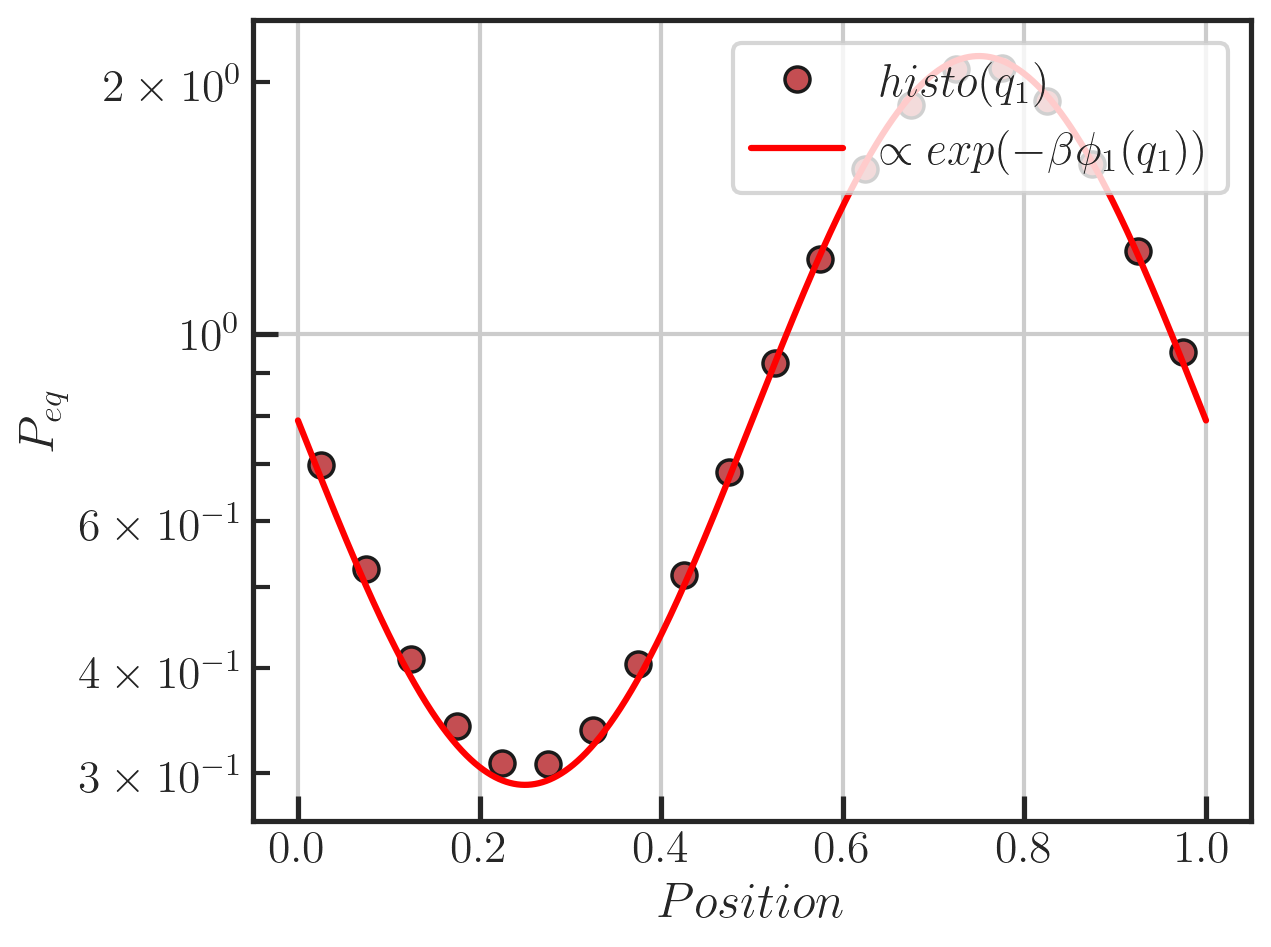

In [9]:
plt.semilogy(q1_bins_center, q1_histo, "ro", label = "$histo (q_1)$")
# plt.plot(q2_bins_center, q2_histo, ".", label = "$histo (q_2)$")
plt.plot(np.linspace(0, l_1, N), Projection_q1, color = "red", label = "$\propto exp(-\\beta \\phi_1(q_1))$")
# plt.plot((np.linspace(-.2, .2, N)), Projection_q2, color = 'k', label = "$\propto exp(-\\beta \\phi_2(q_2))$")


plt.tight_layout()
plt.grid()
plt.xlabel("$Position$")
plt.ylabel("$P_{eq}$")
plt.legend(loc = 'upper right')
plt.show()


# MSDs


In [10]:
def MSD(x, t):
    msd = np.zeros(len(t))
    for n, i in enumerate(t):
        msd[n] = np.nanmean((x[:-i] - x[i:]) ** 2)
    return msd

In [11]:
t = np.hstack([np.arange(10 ** i, 10 ** (i + 1), 10 ** i) for i in range(7)]) # Time lags for MSD plots. Tune the range.
MSD_q1 = MSD(q1, t)
MSD_q2 = MSD(q2, t)

D_q1 = kbT/gamma_11  
D_q2 = kbT/gamma_22

MSD_theo_q1 = D_q1 * t * tau * 2
MSD_theo_q2 = D_q2 * t * tau * 2


# Effective diffusion coefficient

In [12]:
def D_eff_Lifson_Jackson(q1_th, gamma_11, l_1) :
    Deff = l_1**2  / (np.trapz(np.exp(phi_1(q1_th)), q1_th) * np.trapz(np.exp(- phi_1(q1_th)), q1_th) * gamma_11)
    return Deff

def D_eff_Lifson_Jackson_Dean(q1_th, l, kappa) : 
    I1 = np.trapz(np.exp(phi_1(q1_th)), q1_th)
    I2 = np.trapz(np.exp(phi_1(q1_th)) * phi_prime_1(q1_th)**2, q1_th)
    I3 = np.trapz(np.exp(- phi_1(q1_th)), q1_th)
    
    Deff = l**2 / gamma_11 * (I1 * I3)**(-1) * (1 + kappa * gamma_ratio_11**2 * I2 / I1)
    return Deff

In [13]:
q1_th = np.linspace(0, l_1, 1000)

Deff_LJ = D_eff_Lifson_Jackson(q1_th, gamma_11, l_1)
Deff_LJ_Dean = D_eff_Lifson_Jackson_Dean(q1_th, l_1, kappa_2)

/var/folders/cn/hc6sy9vj2vlchg2np1k_bvvh0000gn/T/ipykernel_9713/3841867831.py:2: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  Deff = l_1**2  / (np.trapz(np.exp(phi_1(q1_th)), q1_th) * np.trapz(np.exp(- phi_1(q1_th)), q1_th) * gamma_11)
/var/folders/cn/hc6sy9vj2vlchg2np1k_bvvh0000gn/T/ipykernel_9713/3841867831.py:6: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  I1 = np.trapz(np.exp(phi_1(q1_th)), q1_th)
/var/folders/cn/hc6sy9vj2vlchg2np1k_bvvh0000gn/T/ipykernel_9713/3841867831.py:7: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  I2 = np.trapz(np.exp(phi_1(q1_th)) * phi_prime_1(q1_th)**2, q1_th)
/var/folders/cn/hc6sy9vj2vlchg2np1k_bvvh0000gn/T/ipykernel_9713/3841867831.py:8: DeprecationWarning: `trapz` is deprecated.

In [14]:
MSD_q1

array([7.98583484e-04, 1.57540684e-03, 2.33007946e-03, 3.06385635e-03,
       3.77752451e-03, 4.47094052e-03, 5.14496435e-03, 5.80095337e-03,
       6.43915151e-03, 7.06054865e-03, 1.24381654e-02, 1.65738506e-02,
       1.97968618e-02, 2.23346014e-02, 2.43710667e-02, 2.60134161e-02,
       2.73701079e-02, 2.84925127e-02, 2.94327099e-02, 3.46095318e-02,
       3.77693342e-02, 4.07750259e-02, 4.36789903e-02, 4.64117878e-02,
       4.92579618e-02, 5.19975071e-02, 5.46591393e-02, 5.74212518e-02,
       8.53975777e-02, 1.13120415e-01, 1.40908522e-01, 1.68426363e-01,
       1.95727707e-01, 2.22797765e-01, 2.49812020e-01, 2.76575318e-01,
       3.04281707e-01, 5.75466793e-01, 8.45962080e-01, 1.12220305e+00,
       1.40774772e+00, 1.70335160e+00, 2.01327948e+00, 2.34224429e+00,
       2.70717988e+00, 3.06659802e+00, 5.98551055e+00, 9.09029726e+00,
       1.23911587e+01, 1.48679481e+01, 1.70833858e+01, 1.94742892e+01,
       2.15181475e+01, 2.32486588e+01, 2.50711198e+01, 3.34431067e+01,
      

In [15]:
from scipy.optimize import curve_fit


def fitting_msd_q1(time, a) :
    return a * time # + b

coefficients, errors = curve_fit(fitting_msd_q1, t[35:45]*tau, MSD_q1[35:45])

print (errors)


[[6.02757392e-06]]


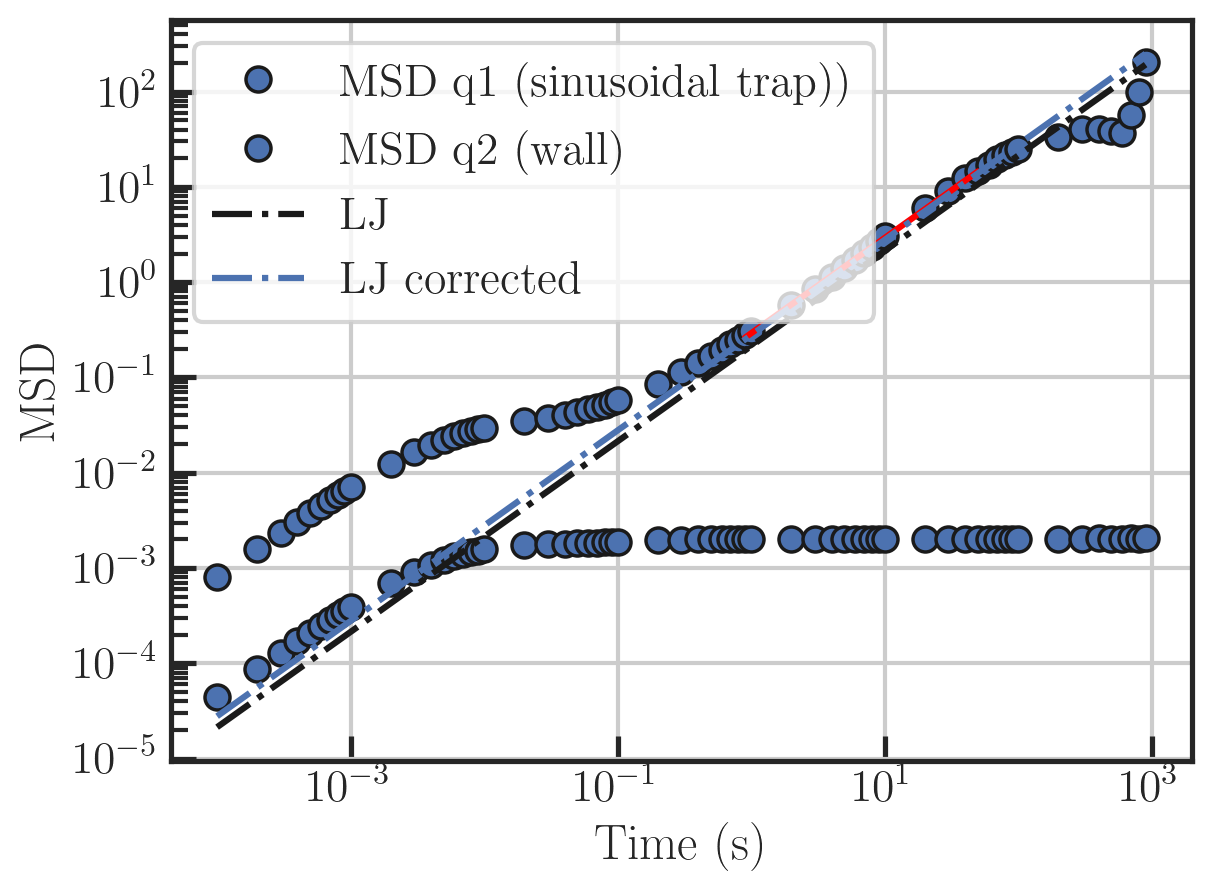

In [22]:
plt.loglog(t*tau, MSD_q1, "bo", label = "MSD q1 (sinusoidal trap))")
# plt.plot(t*tau, MSD_theo_q1)
# plt.plot(t*tau, MSD_theo_q2)

plt.plot(t[35:50]*tau, t[35:50] * tau * coefficients[0], color = 'red')


plt.plot(t*tau, MSD_q2, 'o',  label = "MSD q2 (wall)")

plt.plot(t*tau, 2 * Deff_LJ * t * tau, "-.", color = 'k', label = "LJ")
plt.plot(t*tau,  2 * Deff_LJ_Dean * t * tau, "-.", color = 'b', label = "LJ corrected")
plt.legend(loc = 'upper left')
plt.grid()
plt.xlabel("Time (s)")
plt.ylabel("MSD")
plt.tight_layout()
plt.show()